<a href="https://colab.research.google.com/github/Willyoung2017/Team_Hotpot_11777/blob/main/TextVQA_TextAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
# import re
import spacy
# from collections import Counter

In [ ]:
# Load English language pretrained model from spacy
nlp = spacy.load("en_core_web_sm")

from pandas.io.json import json_normalize

In [ ]:
with open('/content/drive/MyDrive/11777/TextVQA_0.5.1_val.json') as val, \
    open('/content/drive/MyDrive/11777/TextVQA_0.5.1_train.json') as train, \
    open('/content/drive/MyDrive/11777/TextVQA_0.5.1_test.json') as test:
    val_list = json.load(val)
    train_list = json.load(train)
    test_list = json.load(test)

In [ ]:
val_data = pd.json_normalize(val_list, record_path='data')
train_data = pd.json_normalize(train_list, record_path='data')
test_data = pd.json_normalize(test_list, record_path='data')

In [ ]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   question_id          5000 non-null   int64 
 1   question             5000 non-null   object
 2   question_tokens      5000 non-null   object
 3   answers              5000 non-null   object
 4   image_id             5000 non-null   object
 5   image_classes        5000 non-null   object
 6   image_width          5000 non-null   int64 
 7   image_height         5000 non-null   int64 
 8   flickr_original_url  5000 non-null   object
 9   flickr_300k_url      5000 non-null   object
 10  set_name             5000 non-null   object
dtypes: int64(3), object(8)
memory usage: 429.8+ KB


In [ ]:
val_text = val_data[['question_id', 'question', 'question_tokens', 'answers', 'set_name']]
train_text = train_data[['question_id', 'question', 'question_tokens', 'answers', 'set_name']]
test_text = test_data[['question_id', 'question', 'question_tokens', 'set_name']]

In [ ]:
train_text.describe()

,question_id,question_len,answer_num
count,34602.000000,34602.000000,34602.0
mean,17300.500000,7.184758,10.0
std,9988.881344,2.394865,0.0
min,0.000000,2.000000,10.0
25%,8650.250000,6.000000,10.0
50%,17300.500000,7.000000,10.0
75%,25950.750000,8.000000,10.0
max,34601.000000,33.000000,10.0


In [ ]:
val_text.describe()

,question_id,question_len,answer_num
count,5000.000000,5000.000000,5000.0
mean,37101.500000,7.211000,10.0
std,1443.520003,2.448852,0.0
min,34602.000000,2.000000,10.0
25%,35851.750000,6.000000,10.0
50%,37101.500000,7.000000,10.0
75%,38351.250000,8.000000,10.0
max,39601.000000,37.000000,10.0


In [ ]:
val_text.head()

,question_id,question,question_tokens,answers,set_name,question_len,answer_num
0,34602,what is the brand of this camera?,"[what, is, the, brand, of, this, camera]","[nous les gosses, dakota, clos culombu, dakota...",val,7,10
1,34603,what does the small white text spell?,"[what, does, the, small, white, text, spell]","[copenhagen, copenhagen, copenhagen, copenhage...",val,7,10
2,34604,what kind of beer is this?,"[what, kind, of, beer, is, this]","[ale, sublimely self-righteous ale, stone, ale...",val,6,10
3,34605,what brand liquor is on the right?,"[what, brand, liquor, is, on, the, right]","[bowmore , bowmore, bowmore, bowmore, bowmore,...",val,7,10
4,34606,how long has the drink on the right been aged?,"[how, long, has, the, drink, on, the, right, b...","[10 years, 10 year, 10 years, 10 years , 10 ye...",val,10,10


In [ ]:
val_text['question_len'] = val_text.question_tokens.apply(len)
train_text['question_len'] = train_text.question_tokens.apply(len)
test_text['question_len'] = test_text.question_tokens.apply(len)

In [ ]:
val_text['answer_num'] = val_text.answers.apply(len)
train_text['answer_num'] = train_text.answers.apply(len)

In [ ]:
val_questions = list(nlp.pipe(val_data.question))
train_questions = list(nlp.pipe(train_data.question))
test_questions = list(nlp.pipe(test_data.question))

In [ ]:
type(val_questions[0])

spacy.tokens.doc.Doc

In [ ]:
val_10_answers = val_text["answers"].apply(pd.Series)

In [ ]:
expanded_val_answers = val_10_answers.melt()

In [ ]:
expanded_train_answers = train_10_answers.melt()

In [ ]:
train_10_answers = train_text["answers"].apply(pd.Series)

In [ ]:
val_answers = df_to_docs(val_10_answers)
train_answers = df_to_docs(train_10_answers)

In [ ]:
print(len(val_answers))
print(val_10_answers.shape)

50000
(5000, 10)


In [ ]:
val_q_token_data = tab_token_data(val_questions)
train_q_token_data = tab_token_data(train_questions)
test_q_token_data = tab_token_data(test_questions)
val_a_token_data = tab_token_data(val_answers)
train_a_token_data = tab_token_data(train_answers)

In [ ]:
val_q_token_data.query("pos != 'PUNCT'").pos.value_counts()

NOUN     9997
DET      8338
AUX      4829
ADP      4255
PRON     2902
VERB     2207
ADJ      1379
ADV       600
PROPN     583
PART      252
NUM       181
CCONJ      68
SCONJ      53
SYM        18
SPACE       9
X           8
INTJ        6
Name: pos, dtype: int64

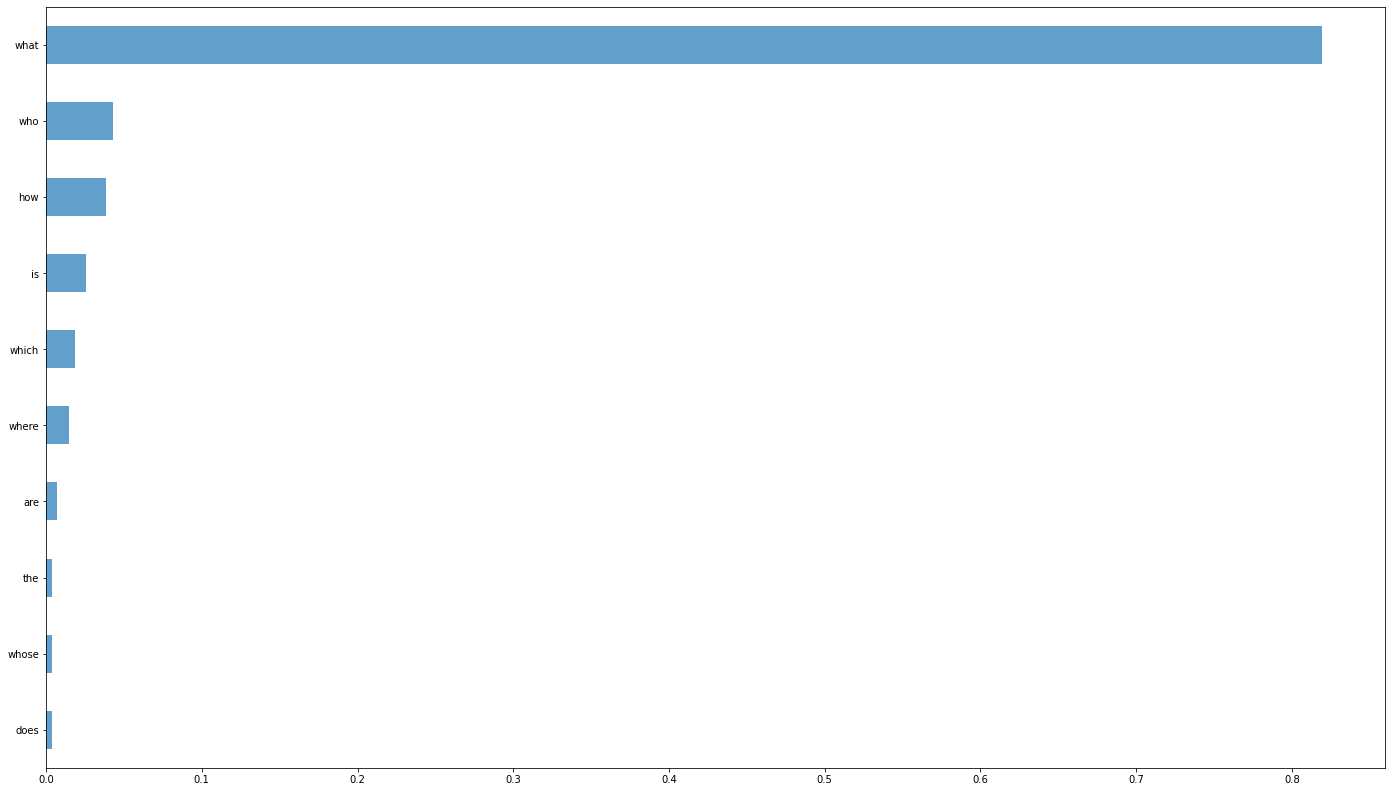

In [ ]:
import csv
def analyze_questions(text_df, token_data, prefix, path):
    
    avg_question_len = text_df['question_len'].mean()
    median_question_len = text_df['question_len'].median()
    std_dev_question_len = text_df['question_len'].std()
    with open(path + prefix + 'question_metrics.txt', 'w') as metrics_file:
        tsv_writer = csv.writer(metrics_file, delimiter='\t')
        tsv_writer.writerow(['avg question length: ' + "%.2f" % avg_question_len])
        tsv_writer.writerow(['median question length: ' + "%.2f" % median_question_len])
        tsv_writer.writerow(['std dev of question length: ' + "%.2f" % std_dev_question_len])

    
    plt.clf()
    # text_df['capped_question_len'] = text_df.apply(lambda x: x['question_len'] if x['question_len'] <= 20 else 20, axis=1)
    text_df.capped_question_len.hist(figsize=(14, 7), range=(0, 20), color="red", alpha=.4, bins=20)
    plt.savefig(path + prefix + 'question_length.png')
    

    plt.clf()
    text_df.question.value_counts().head(10).plot(kind="barh", figsize=(30, 14), color='green', alpha=.7)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.savefig(path + prefix + '10_most_frequent_questions.png')

    
    plt.clf()
    first_word = token_data[token_data['token_order'] == 0].token.value_counts()
    first_word = first_word / first_word.sum()
    ax = first_word.head(10).plot(kind="barh", figsize=(24, 14), alpha=.7)
    ax.invert_yaxis()
    plt.savefig(path + prefix + 'distribution_of_10_most_frequent_question_starting_words.png')
    
    plt.clf()
    word_token = token_data.query("pos != 'PUNCT'").pos.value_counts()
    word_token = word_token / word_token.sum()
    ax = word_token.head(10).plot(kind="barh", figsize=(24, 14), color='orange', alpha=.7)
    ax.invert_yaxis()
    plt.savefig(path + prefix + 'distribution_of_10_most_frequent_word_classes_in_questions.png')
    
    

path = '/content/drive/MyDrive/11777/'
analyze_questions(val_text, val_q_token_data, 'val_', path)
analyze_questions(train_text, train_q_token_data, 'train_', path)
analyze_questions(test_text, test_q_token_data, 'test_', path)

In [ ]:
def analyze_answers(expanded_answers, text_df, token_data, prefix, path):
    
    avg_answer_len = token_data.groupby('doc_id').size().mean()
    median_answer_len = token_data.groupby('doc_id').size().median()
    std_dev_answer_len = token_data.groupby('doc_id').size().std()
    with open(path + prefix + 'answer_metrics.txt', 'w') as metrics_file:
        tsv_writer = csv.writer(metrics_file, delimiter='\t')
        tsv_writer.writerow(['avg answer length: ' + "%.2f" % avg_answer_len])
        tsv_writer.writerow(['median answer length: ' + "%.2f" % median_answer_len])
        tsv_writer.writerow(['std dev of answer length: ' + "%.2f" % std_dev_answer_len])

    
    plt.clf()
    counts = expanded_val_answers.value.value_counts()
    counts = counts / 10
    counts.head(10).plot(kind="barh", figsize=(32, 14), color='green', alpha=.7)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.savefig(path + prefix + '10_most_frequent_answers.png')
    
    plt.clf()
    word_token = token_data.query("pos != 'PUNCT'").pos.value_counts()
    word_token = word_token / word_token.sum()
    ax = word_token.head(10).plot(kind="barh", figsize=(24, 14), color='orange', alpha=.7)
    ax.invert_yaxis()
    plt.savefig(path + prefix + 'distribution_of_10_most_frequent_word_classes_in_answers.png')
    
    

path = '/content/drive/MyDrive/11777/'
analyze_answers(expanded_val_answers, val_text, val_a_token_data, 'val_', path)
analyze_answers(expanded_train_answers, train_text, train_a_token_data, 'train_', path)

In [ ]:
val_a_token_data.groupby('doc_id').size().mean()

In [ ]:
val_q_first_word = val_q_token_data[val_q_token_data['token_order'] == 0].token.value_counts()

In [ ]:
val_q_first_word = val_q_first_word / val_q_first_word.size

In [ ]:
val_q_first_word.head()

what     0.7854
who      0.0478
how      0.0368
is       0.0324
which      0.02
Name: token, dtype: object

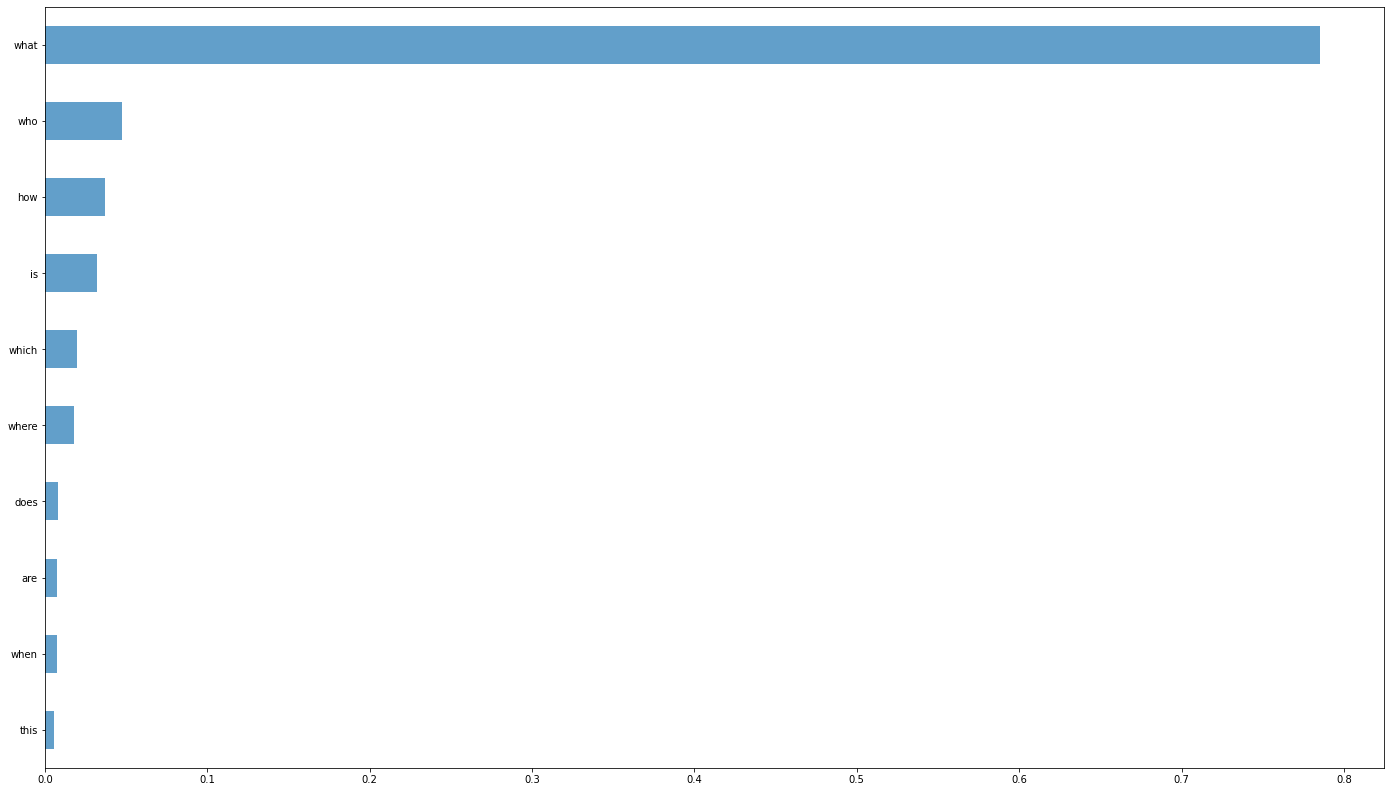

In [ ]:
ax = val_q_first_word.head(10).plot(kind="barh", figsize=(24, 14), alpha=.7)
ax.invert_yaxis()
plt.save()

In [ ]:
val_q_token_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40842 entries, 0 to 5
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_id       40842 non-null  int64 
 1   token        40842 non-null  object
 2   token_order  40842 non-null  int64 
 3   pos          40842 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.6+ MB


In [ ]:
def df_to_docs(df):
    docs = []
    for name, series in df.items():
        docs = docs + list(nlp.pipe(series))
    return docs

In [ ]:
def extract_tokens_plus_meta(doc):
    return [
        (i.text, i.i, i.pos_) for i in doc
    ]

In [ ]:
def tab_token_data(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "pos"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df)  

In [ ]:
spacy.explain('PART')

'particle'